# EDA (Exploratory Data Analysis)

In [ ]:
import pandas as pd
from zipfile import ZipFile

# 데이터 경로
data_path = './aerial-cactus-identification/'

# 훈련 이미지 데이터 압출 풀기
with ZipFile('./aerial-cactus-identification.zip') as zipper:
    zipper.extractall(data_path)

labels = pd.read_csv(data_path + 'train.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

## 데이터 시각화

### 타깃값 분포

([<matplotlib.patches.Wedge at 0x7fdd0e5b0ee0>,
 [Text(-0.7793519565739234, 0.7762799287527649, 'Yes cactus'),
  Text(0.7793519929142085, -0.776279892268666, 'No cactus')],
 [Text(-0.42510106722213997, 0.42342541568332626, '75.1%'),
  Text(0.4251010870441137, -0.42342539578290866, '24.9%')])

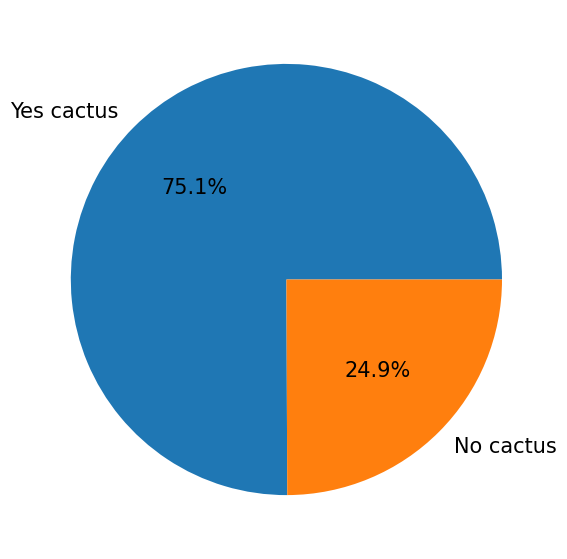

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=15)
plt.figure(figsize=(7,7))

label = ['Yes cactus', 'No cactus'] # 타깃값 레이블
# 타깃값 분포 파이 그래프
plt.pie(labels['has_cactus'].value_counts(), labels=label, autopct='%.1f%%')

### 이미지 출력

In [ ]:
from zipfile import ZipFile

# 훈련 이미지 데이터 압출 풀기
with ZipFile(data_path + 'train.zip') as zipper:
    zipper.extractall(path='./data')

with ZipFile(data_path + 'test.zip') as zipper:
    zipper.extractall(path='./data')

In [ ]:
import  os

num_train = len(os.listdir('./data/train/'))
num_test = len(os.listdir('./data/test/'))

print(f'훈련 데이터 개수: {num_train}')
print(f'테스트 데이터 개수: {num_test}')

훈련 데이터 개수: 17500
테스트 데이터 개수: 4000


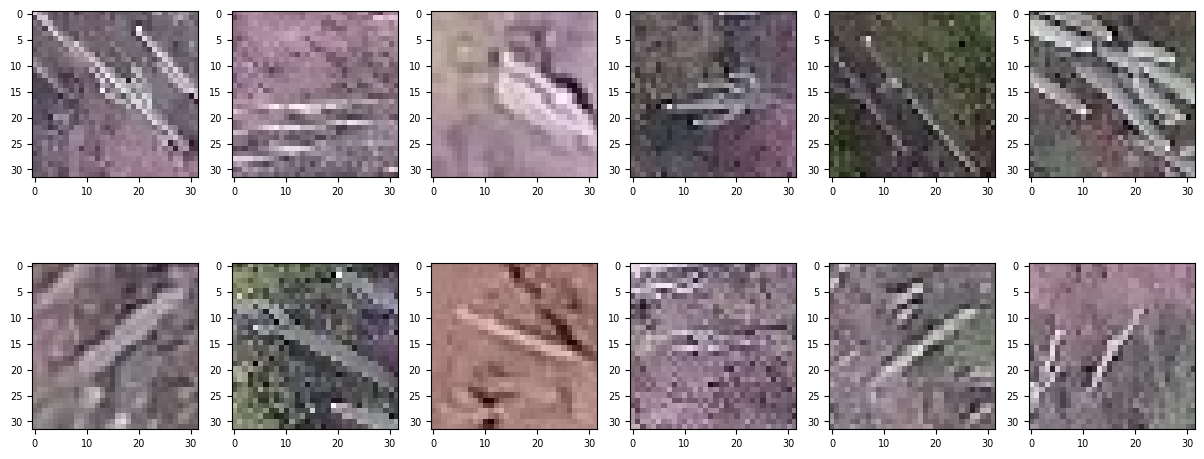

In [ ]:
import  matplotlib.gridspec as gridspec
import cv2 # OpenCV 라이브러리 임포트

mpl.rc('font', size=7)
plt.figure(figsize=(15, 6)) # 전체 Figure 크기 설정
grid = gridspec.GridSpec(2,6) # 서브플롯 배치(2행 6열로 출력)

# 선인장 이미지 마지막 12개만
last_has_cactus_img_name = labels[labels['has_cactus']==1]['id'][-12:]

# 이미지 출력
for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = './data/train/' + img_name # 이미지 파일 경로
    image = cv2.imread(img_path) # 이미지 파일 읽기
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)

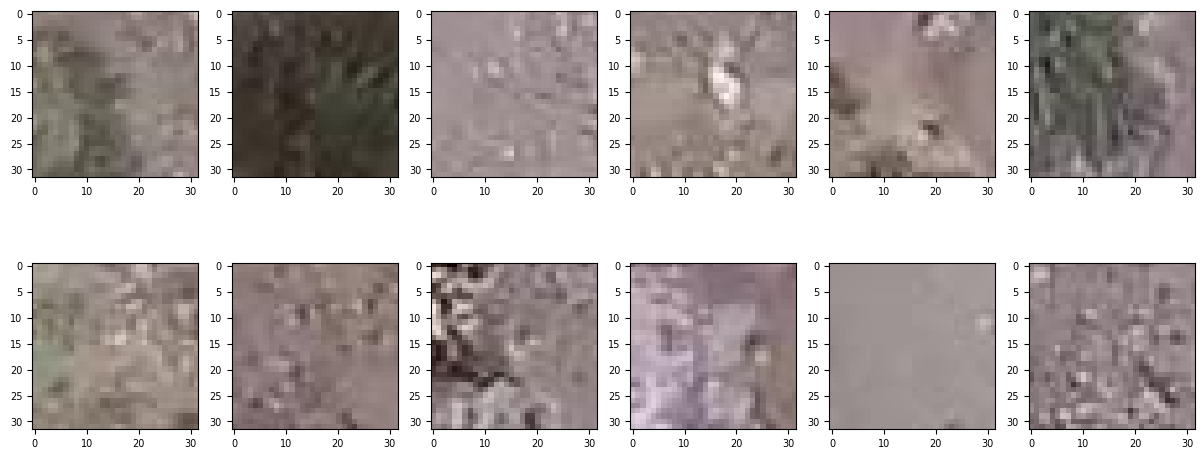

In [ ]:
plt.figure(figsize=(15, 6)) # 전체 Figure 크기 설정
grid = gridspec.GridSpec(2,6) # 서브플롯 배치(2행 6열로 출력)

# 선인장 이미지 마지막 12개만
last_hasnt_cactus_img_name = labels[labels['has_cactus']==0]['id'][-12:]

# 이미지 출력
for idx, img_name in enumerate(last_hasnt_cactus_img_name):
    img_path = './data/train/' + img_name # 이미지 파일 경로
    image = cv2.imread(img_path) # 이미지 파일 읽기
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)

# Baseline model

## 시드값 고정 및 GPU 장비 설정

In [ ]:
import torch # 파이토치 
import random
import numpy as np
import os

# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)                # 파이썬 난수 생성기 시드 고정
np.random.seed(seed)             # 넘파이 난수 생성기 시드 고정
torch.manual_seed(seed)          # 파이토치 난수 생성기 시드 고정 (CPU 사용 시)
torch.cuda.manual_seed(seed)     # 파이토치 난수 생성기 시드 고정 (GPU 사용 시)
torch.cuda.manual_seed_all(seed) # 파이토치 난수 생성기 시드 고정 (멀티GPU 사용 시)
torch.backends.cudnn.deterministic = True # 확정적 연산 사용
torch.backends.cudnn.benchmark = False    # 벤치마크 기능 해제
torch.backends.cudnn.enabled = False      # cudnn 사용 해제

### GPU 장비 설정

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
device

device(type='cuda')

## 데이터 준비

In [ ]:
from sklearn.model_selection import train_test_split

train_no_strat, valid_no_strat = train_test_split(labels, 
                                test_size=0.1,
                                random_state=50)

train, valid = train_test_split(labels, 
                                test_size=0.1,
                                stratify=labels['has_cactus'],
                                random_state=50)
# stratify로 has cactus의 3:1 비율대로 train valid set을 뽑아줌줌

In [ ]:
print(train_no_strat['has_cactus'].value_counts())
print(valid_no_strat['has_cactus'].value_counts())
print(train['has_cactus'].value_counts())
print(valid['has_cactus'].value_counts())

# stratify를 하면 has cactus의 비율대로 뽑아주는게 보장되지만
# 데이터가 많을때에는 딱히 하지 않아도 괜찮을듯

1    11815
0     3935
Name: has_cactus, dtype: int64
1    1321
0     429
Name: has_cactus, dtype: int64
1    11822
0     3928
Name: has_cactus, dtype: int64
1    1314
0     436
Name: has_cactus, dtype: int64


### 데이터셋 클래스 정의

In [ ]:
import cv2 # OpenCV 라이브러리
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스

# Dataset은 추상클래스여서 len와 getitem을 override해야한다.
class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', transform=None):
        super().__init__() # 상속받은 Dataset의 생성자 호출
        # 전달받은 인수들 저장
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
    
    # 데이터셋 크기 반환 메서드 
    def __len__(self):
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 반환 메서드 
    def __getitem__(self, idx):
        # df iloc 는 row 가져오는 함수
        img_id = self.df.iloc[idx, 0]    # 이미지 ID
        img_path = self.img_dir + img_id # 이미지 파일 경로 
        image = cv2.imread(img_path)     # 이미지 파일 읽기 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        label = self.df.iloc[idx, 1]     # 이미지 레이블(타깃값)

        if self.transform is not None:
            image = self.transform(image) # 변환기가 있다면 이미지 변환
        return image, label

### 데이터셋 생성

In [ ]:
from torchvision import transforms # 이미지 변환을 위한 모듈

transform = transforms.ToTensor()
# ToTensor를 적용시키면 이미지를 텐서로 바꿀 수 있음
# 이때 (가로, 세로, 채널)이 (채널, 가로, 세로)로 바뀐다.
# 파이토치에서는 (채널, 가로, 세로)로 이미지를 처리하기 때문이다.
# 배치로 묵으면 (배치크기, 채널, 가로, 세로)가 된다.

In [ ]:
dataset_train = ImageDataset(df=train, img_dir='./data/train/', transform=transform)
dataset_valid = ImageDataset(df=valid, img_dir='./data/train/', transform=transform)

### 데이터 로더 생성

In [ ]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

# train을 shuffle하는 이유는 모델이 순서를 외우도록 학습되는 것을 피하기 위함
loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
# 어차피 validation은 학습에 참여하지 않기 떄문에 shuffle하지 않아도 돼
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False)

# 배치크기의 영향?
# 배치크기가 작으면 Regularization 효과가 있다 -> 아무래도 작은 data를 믿고 가다보니
# noise를 더 받기에 Regularization 효과가 있다고 해석하는 듯.
# 배치크기가 크면 한번 갈 때 정확히 갈 수 있지만, 훈련 시간이 길어진다.

## 모델 생성

In [ ]:
import torch.nn as nn # 신경망 모듈
import torch.nn.functional as F # 신경망 모듈에서 자주 사용되는 함수

class Model(nn.Module):
    # 신경망 계층 정의 
    def __init__(self):
        super().__init__() # 상속받은 nn.Module의 __init__() 메서드 호출

        # Stride는 기본값 1 사용용
        # 첫 번째 합성곱 계층 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, 
                               kernel_size=3, padding=2) 
        # 두 번째 합성곱 계층 
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, 
                               kernel_size=3, padding=2) 
        
        # 풀링에서 Stride parameter을 명시하지 않으면
        # 풀링 크기와 같은 값이 설정됨

        # 최대 풀링 계층 
        self.max_pool = nn.MaxPool2d(kernel_size=2) 
        # 평균 풀링 계층 
        self.avg_pool = nn.AvgPool2d(kernel_size=2) 
        # 전결합 계층 
        self.fc = nn.Linear(in_features=64 * 4 * 4, out_features=2)
        
    # 순전파 출력 정의 
    def forward(self, x):
        x = self.max_pool(F.relu(self.conv1(x)))
        x = self.max_pool(F.relu(self.conv2(x)))
        x = self.avg_pool(x)
        x = x.view(-1, 64 * 4 * 4) # 평탄화
        x = self.fc(x)
        return x

In [ ]:
model = Model().to(device)

model

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)

## 모델 훈련

### 손실 함수 설정

In [ ]:
# 손실함수
# 분류이기에 EntropyLoss(정확히는 BCE사용)
criterion = nn.CrossEntropyLoss()

### 옵티마이저 설정

In [ ]:
# 옵티마이저
# 예제 코드에서는 간단히 SGD를 사용
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
epochs = 10 # 총 에폭

train_avg_costs = []
valid_avg_costs = []

valid_batch_num = len(loader_valid)
train_batch_num = len(loader_train)

# 총 에폭만큼 반복
for epoch in range(epochs):
    avg_cost = 0
    epoch_loss = 0 # 에폭별 손실값 초기화
    
    # '반복 횟수'만큼 반복 
    for images, labels in loader_train:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가
        epoch_loss += loss.item() 
        # 역전파 수행
        loss.backward()
        # 가중치 갱신
        optimizer.step()

        avg_cost += loss / train_batch_num

    train_avg_costs.append(avg_cost.detach().cpu().numpy())
        
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 손실값: {epoch_loss/len(loader_train):.4f}')

    test_avg_cost = 0
    model.eval()
    for images, labels in loader_valid:
        images = images.to(device)
        with torch.no_grad():
            logits = model(images)
            test_loss = criterion(logits, labels.to(device))
        test_avg_cost += test_loss / valid_batch_num
    valid_avg_costs.append(test_avg_cost.detach().cpu().numpy())
    

에폭 [1/10] - 손실값: 0.5303
에폭 [2/10] - 손실값: 0.3683
에폭 [3/10] - 손실값: 0.2539
에폭 [4/10] - 손실값: 0.2060
에폭 [5/10] - 손실값: 0.1793
에폭 [6/10] - 손실값: 0.1623
에폭 [7/10] - 손실값: 0.1518
에폭 [8/10] - 손실값: 0.1366
에폭 [9/10] - 손실값: 0.1346
에폭 [10/10] - 손실값: 0.1255


<ipython-input-111-bc377be4c57a>:9: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend([line1, line2], ['train_avg_cost', 'test_avg_cost'])


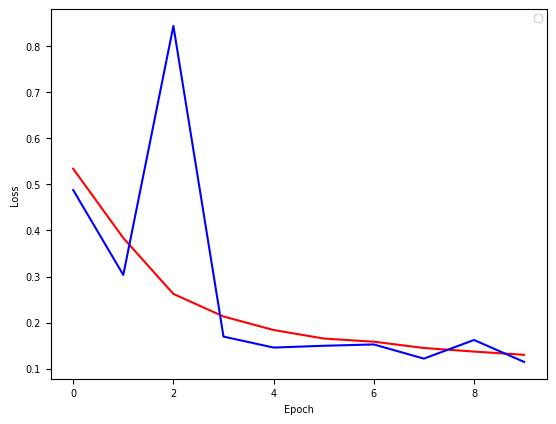

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epoch = range(epochs)
line1 = plt.plot(epoch, train_avg_costs, 'r-')
line2 = plt.plot(epoch, valid_avg_costs, 'b-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend([line1, line2], ['train_avg_cost', 'test_avg_cost'])
plt.show()

## 성능 검증

In [ ]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수 임포트

# 실제값과 예측 확률값을 담을 리스트 초기화
true_list = []
preds_list = []

In [ ]:
model.eval() # 모델을 평가 상태로 설정 
# eval()시 드롭아웃, 배치 normalization을 적용시키지 않음

with torch.no_grad(): # 기울기 계산 비활성화
# backward()를 쓰지 않는다면 상관없지만, memory 효율적
    for images, labels in loader_valid:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device) 
        
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        preds = torch.softmax(outputs.cpu(), dim=1)[:, 1] # 예측 확률
        true = labels.cpu() # 실제값 
        # 예측 확률과 실제값을 리스트에 추가
        preds_list.extend(preds)
        true_list.extend(true)
        
# 검증 데이터 ROC AUC 점수 계산
print(f'검증 데이터 ROC AUC : {roc_auc_score(true_list, preds_list):.4f}')

검증 데이터 ROC AUC : 0.9903


# 성능개선

## 이미지 변환기 정의

In [ ]:
from torchvision import transforms # 이미지 변환을 위한 모듈
# transforms.Pad() 이미지 주변에 패딩을 추가
# padding_mode='symmetric'은 패딩 추가시, 원본 데이터를 상하 좌우 대칭이 되는 모양으로 추가
# 32의 크기의 원본 이미지가 있었다면 96 크기의 이미지를 만들어줌

# RandomHorizontalFlip, RandomVerticalFlip
# 무작위로 이미지를 좌우, 상하 대칭 변환함

# RandomRotation
# 이미지를 화전시킴, 10을 파라미터로 전달할 시 -10 ~ 10도 사이의 값만큼
# 무작위로 회전시킴

# Normalize
# RGB channel의 각 평균과 분산을 구하여 Normalize해도 좋지만
# 이미지넷 데이터에서 얻은 0.485... 대게 이 값을 그대로 사용

# 훈련 데이터용 변환기
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Pad(32, padding_mode='symmetric'),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.Normalize((0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225))])

# 검증 및 테스트 데이터용 변환기
transform_test= transforms.Compose([transforms.ToTensor(),
                                    transforms.Pad(32, padding_mode='symmetric'),
                                    transforms.Normalize((0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225))])

### 데이터셋 및 데이터 로더 생성

In [ ]:
dataset_train = ImageDataset(df=train, img_dir='./data/train/', transform=transform_train)
dataset_valid = ImageDataset(df=valid, img_dir='./data/train/', transform=transform_test)

In [ ]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False)

# transform 때문에 epoch마다 다른 이미지로 학습될 것임임

## 모델 생성

In [ ]:
import torch.nn as nn # 신경망 모듈
import torch.nn.functional as F # 신경망 모듈에서 자주 사용되는 함수

# 신경망 계층이 깊어지면 대체로 예측력이 좋아지지만,
# 지나치게 깊으면 모델의 표현력이 너무 좋아져 overfitting의 가능성 증가
# (그림 설명)
# Regularization의 원리 설명, weight 값과의 연관성

# Why batchnorm works?
# internal covariate shift (내부 공변량 변화)
# 참고 Covariate shift (공변량 변화)

class Model(nn.Module):
    # 신경망 계층 정의
    def __init__(self):
        super().__init__() # 상속받은 nn.Module의 __init__() 메서드 호출
        # 1 ~ 5번째 {합성곱, 배치 정규화, 최대 풀링} 계층 
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(32), # 배치 정규화
                                    nn.LeakyReLU(), # LeakyReLU 활성화 함수
                                    nn.MaxPool2d(kernel_size=2))

        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(64),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer5 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        # 평균 풀링 계층 
        self.avg_pool = nn.AvgPool2d(kernel_size=4) 
        # 전결합 계층
        self.fc1 = nn.Linear(in_features=512 * 1 * 1, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=2)

    # 순전파 출력 정의 
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avg_pool(x)
        x = x.view(-1, 512 * 1 * 1) # 평탄화
        x = self.fc1(x)
        x = self.fc2(x)
        return x

### 손실 함수와 옵티마이저 설정

In [ ]:
model = Model().to(device)
# 손실 함수
criterion = nn.CrossEntropyLoss()
# 옵티마이저
# Adamax는 Adam의 개선 버전
optimizer = torch.optim.Adamax(model.parameters(), lr=0.00006)

### 모델 훈련

In [ ]:
epochs = 30 # 총 에폭

train_avg_costs = []
valid_avg_costs = []

valid_batch_num = len(loader_valid)
train_batch_num = len(loader_train)

# 총 에폭만큼 반복
for epoch in range(epochs):
    avg_cost = 0
    epoch_loss = 0 # 에폭별 손실값 초기화
    
    # '반복 횟수'만큼 반복 
    for images, labels in loader_train:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가
        epoch_loss += loss.item() 
        # 역전파 수행
        loss.backward()
        # 가중치 갱신
        optimizer.step()

        avg_cost += loss / train_batch_num

    train_avg_costs.append(avg_cost.detach().cpu().numpy())
        
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 손실값: {epoch_loss/len(loader_train):.4f}')

    test_avg_cost = 0
    model.eval()
    for images, labels in loader_valid:
        images = images.to(device)
        with torch.no_grad():
            logits = model(images)
            test_loss = criterion(logits, labels.to(device))
        test_avg_cost += test_loss / valid_batch_num
    valid_avg_costs.append(test_avg_cost.detach().cpu().numpy())
    

에폭 [1/30] - 손실값: 0.1243
에폭 [2/30] - 손실값: 0.0664
에폭 [3/30] - 손실값: 0.0475
에폭 [4/30] - 손실값: 0.0455
에폭 [5/30] - 손실값: 0.0407
에폭 [6/30] - 손실값: 0.0365
에폭 [7/30] - 손실값: 0.0348
에폭 [8/30] - 손실값: 0.0322
에폭 [9/30] - 손실값: 0.0310
에폭 [10/30] - 손실값: 0.0268
에폭 [11/30] - 손실값: 0.0249
에폭 [12/30] - 손실값: 0.0249
에폭 [13/30] - 손실값: 0.0257
에폭 [14/30] - 손실값: 0.0249
에폭 [15/30] - 손실값: 0.0219
에폭 [16/30] - 손실값: 0.0225
에폭 [17/30] - 손실값: 0.0217
에폭 [18/30] - 손실값: 0.0216
에폭 [19/30] - 손실값: 0.0188
에폭 [20/30] - 손실값: 0.0212
에폭 [21/30] - 손실값: 0.0170
에폭 [22/30] - 손실값: 0.0176
에폭 [23/30] - 손실값: 0.0154
에폭 [24/30] - 손실값: 0.0151
에폭 [25/30] - 손실값: 0.0152
에폭 [26/30] - 손실값: 0.0169
에폭 [27/30] - 손실값: 0.0144
에폭 [28/30] - 손실값: 0.0128
에폭 [29/30] - 손실값: 0.0145
에폭 [30/30] - 손실값: 0.0137


<ipython-input-155-bc377be4c57a>:9: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend([line1, line2], ['train_avg_cost', 'test_avg_cost'])


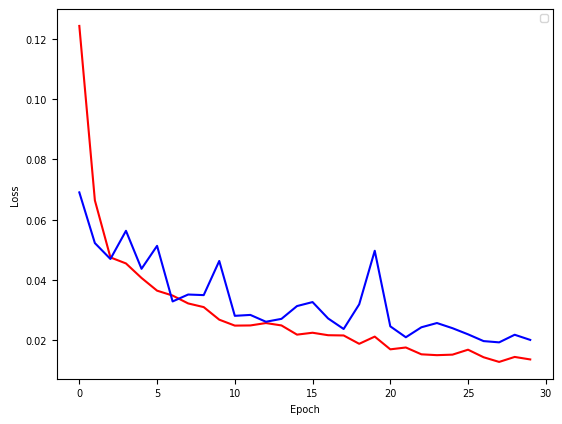

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epoch = range(epochs)
line1 = plt.plot(epoch, train_avg_costs, 'r-')
line2 = plt.plot(epoch, valid_avg_costs, 'b-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend([line1, line2], ['train_avg_cost', 'test_avg_cost'])
plt.show()

## 예측 및 결과 제출

In [ ]:
dataset_test = ImageDataset(df=submission, img_dir='test/', transform=transform)
loader_test = DataLoader(dataset=dataset_test, batch_size=32, shuffle=False)

In [ ]:
model.eval() # 모델을 평가 상태로 설정

preds = [] # 타깃 예측값 저장용 리스트 초기화

with torch.no_grad(): # 기울기 계산 비활성화
    for images, _ in loader_test:
        # 이미지 데이터 미니배치를 장비에 할당
        images = images.to(device)
        
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 타깃값이 1일 확률(예측값)
        preds_part = torch.softmax(outputs.cpu(), dim=1)[:, 1].tolist()
        # preds에 preds_part 이어붙이기
        preds.extend(preds_part)

### 결과 제출

In [ ]:
submission['has_cactus'] = preds
submission.to_csv('submission.csv', index=False)

In [ ]:
import shutil

shutil.rmtree('./train')
shutil.rmtree('./test')